C:\Users\Admin\AppData\Local\Temp\ipykernel_14152\3580208518.py:62: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
C:\Users\Admin\AppData\Local\Temp\ipykernel_14152\3580208518.py:86: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


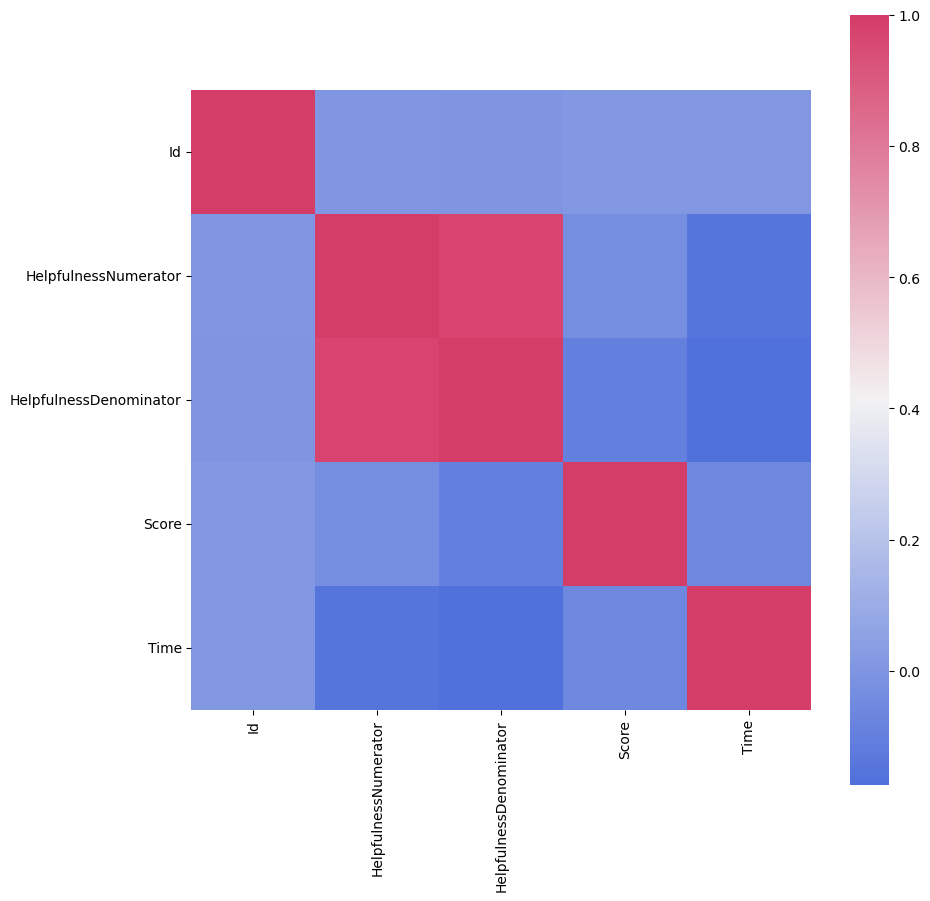

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.





import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet


#importing the training data
df=pd.read_csv('Reviews(1).csv')
df.head()


#Summary of the dataset
df.describe()




# Define function to remove HTML tags using BeautifulSoup
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()
#Removing the square brackets
# Define function to remove URLs
def remove_urls(text):
    return re.sub(r'http\S+', '', text)

# Define function to remove square brackets
def remove_between_square_brackets(text):
    return re.sub(r'\[[^]]*\]', '', text)


#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text


#Apply function on review column
df['Text']=df['Text'].apply(denoise_text)


plt.figure(figsize=(10, 10))
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=bool), cmap=sns.diverging_palette(-100, 0, as_cmap=True), square=True)
plt.show()








In [2]:
del df['Id']
del df['Time']
del df['UserId']
del df['ProductId']
del df['HelpfulnessNumerator']
del df['HelpfulnessDenominator']

In [3]:
df['Text'] = df['Text'] + ' ' + df['Summary'] + ' ' + df['ProfileName']
del df['Summary']
del df['ProfileName']
df.head()

,Score,Text
0,5,I have bought several of the Vitality canned d...
1,1,Product arrived labeled as Jumbo Salted Peanut...
2,4,This is a confection that has been around a fe...
3,2,If you are looking for the secret ingredient i...
4,5,Great taffy at a great price. There was a wid...


In [4]:
def score_sentiment(score):
    # Replace scores of 1,2,3 with 0 (not good) and 4,5 with 1 (good)
    if(score == 1 or score == 2 or score == 3):
        return 0
    else:
        return 1
df.Score = df.Score.apply(score_sentiment)    

In [5]:
df.isna().sum()

Score     0
Text     43
dtype: int64

In [6]:
df.Text.fillna("",inplace = True)

In [10]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [11]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [12]:
stemmer = PorterStemmer()
def stem_text(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            word = stemmer.stem(i.strip())
            final_text.append(word)
    return " ".join(final_text)

In [ ]:
df.Text = df.Text.apply(stem_text)

In [ ]:
plt.figure(figsize = (20,20)) # Text with bad/average reviews
wc = WordCloud(max_words = 3000 , width = 1600 , height = 800).generate(" ".join(df[df.Score == 0].Text))
plt.imshow(wc , interpolation = 'bilinear')

In [ ]:
plt.figure(figsize = (20,20)) # Text with good reviews
wc = WordCloud(max_words = 3000 , width = 1600 , height = 800).generate(" ".join(df[df.Score ==1].Text))
plt.imshow(wc , interpolation = 'bilinear')

In [15]:
x_train,x_test,y_train,y_test = train_test_split(df.Text,df.Score,random_state = 0)

In [16]:
cv=CountVectorizer(min_df=0,max_df=1,ngram_range=(1,2))
#transformed train reviews
cv_train_reviews=cv.fit_transform(x_train)
#transformed test reviews
cv_test_reviews=cv.transform(x_test)

print('BOW_cv_train:',cv_train_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)

BOW_cv_train: (426340, 1914860)
BOW_cv_test: (142114, 1914860)


In [22]:
lr=LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=0)
#Fitting the model for Bag of words
lr_bow=lr.fit(cv_train_reviews,y_train)
print(lr_bow)

LogisticRegression(C=1, max_iter=500, random_state=0)


In [23]:
#Predicting the model for bag of words
lr_bow_predict=lr.predict(cv_test_reviews)

In [24]:
#Accuracy score for bag of words
lr_bow_score=accuracy_score(y_test,lr_bow_predict)
print("lr_bow_score :",lr_bow_score)

lr_bow_score : 0.7988727359725291


In [25]:
#Classification report for bag of words
lr_bow_report=classification_report(y_test,lr_bow_predict,target_names=['0','1'])
print(lr_bow_report)

              precision    recall  f1-score   support

           0       0.97      0.08      0.16     31133
           1       0.80      1.00      0.89    110981

    accuracy                           0.80    142114
   macro avg       0.88      0.54      0.52    142114
weighted avg       0.83      0.80      0.73    142114

